# 3. SVM

## 3.1. Import modules and data(공통)

In [4]:
# 프로젝트에 필요한 파이썬 모듈들을 불러옵니다
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [5]:
# Read Data from Adult dataset, and add name of columns
# There are missing values represented as '?', so treat '?' as NaN
df = pd.read_csv('adult.csv', na_values='?')
df.columns = ["Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
              "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
              "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"]
display(df.head(10))
print(df.shape)

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
6,29,NaN,227026,HS-grad,9,Never-married,NaN,Unmarried,Black,Male,0,0,40,United-States,<=50K
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
8,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
9,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K


(48842, 15)


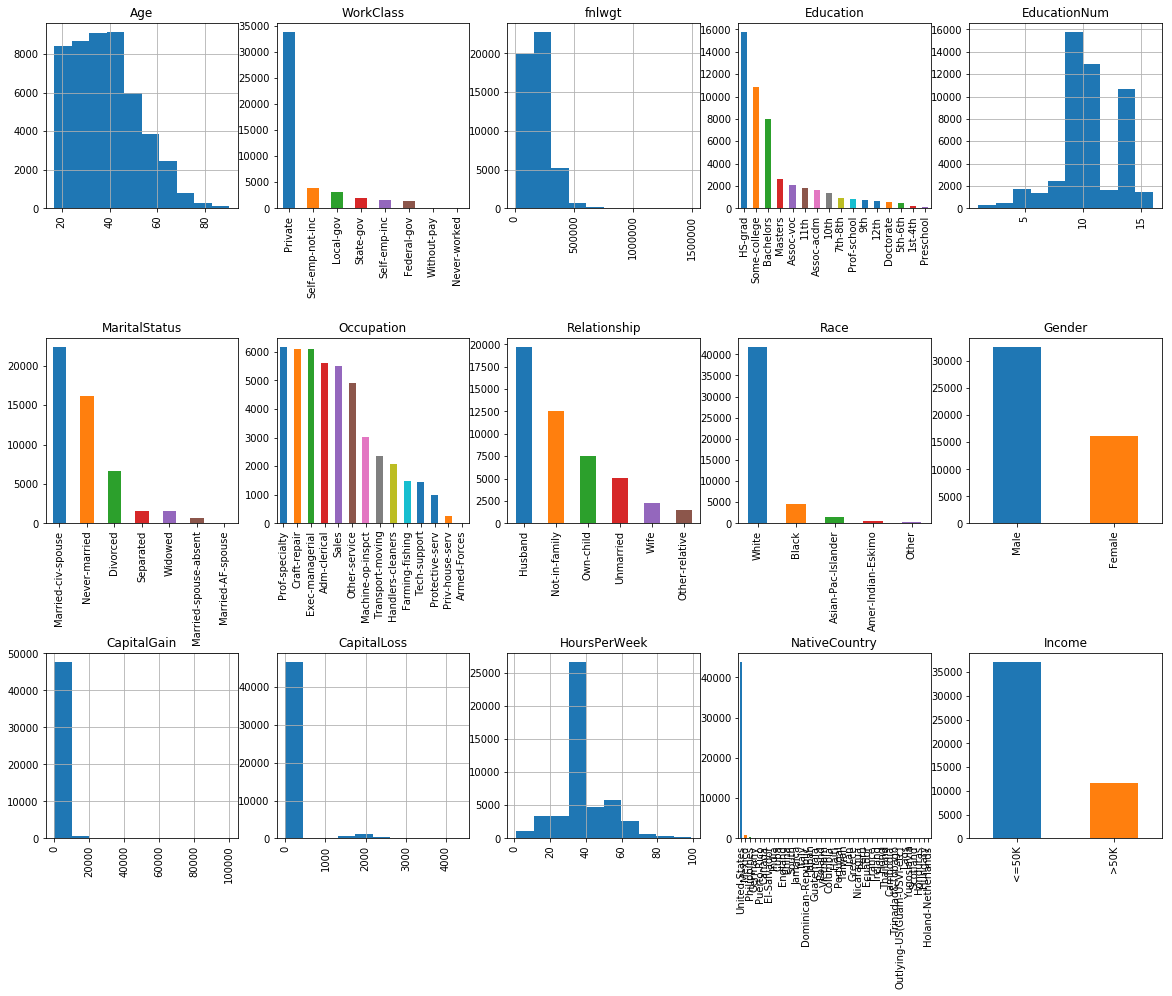

In [6]:
fig = plt.figure(figsize=(20,15))
cols = 5
rows = df.shape[1] / cols
for i, column in enumerate(df.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if df.dtypes[column] == np.object:
        df[column].value_counts().plot(kind="bar", axes=ax)
    else:
        df[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

## 3.2. Preprocessing
work class, occupation은 most frequent value로 imputation하였습니다. education의 label을 일관성있게 변환하였습니다. 국적이 미국이 아닌 row를 drop하였습니다. quality data는 one hot encoding 처리하였습니다.

## 3.2.1. Removing redundancy & relabeling features

In [7]:
#원래 dataframe에서 가공한 데이터 객체의 이름을 adult라고 따로 명명한 뒤, redundant한 column인 'EducationNumber'를 drop합니다.
adult = df.drop(['EducationNum'], axis=1)

#국적이 미국이 아닌 행을 drop합니다.
indexNames = adult[adult['NativeCountry'] != 'United-States'].index
adult.drop(indexNames, inplace=True)

#string으로 주어졌던 income을 50K 초과면 1, 이하면 0으로 encoding합니다.
adult.Income = adult.Income.map({'>50K':1, '<=50K':0}) #Income encoding
adult

,Age,WorkClass,fnlwgt,Education,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,25,Private,226802,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,NaN,103497,Some-college,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,0
5,34,Private,198693,10th,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,0
6,29,NaN,227026,HS-grad,Never-married,NaN,Unmarried,Black,Male,0,0,40,United-States,0
7,63,Self-emp-not-inc,104626,Prof-school,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,1
8,24,Private,369667,Some-college,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,0
9,55,Private,104996,7th-8th,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,0


In [8]:
#Education의 label이 일관적이지 않음을 확인할 수 있습니다.(artifact)
print('Education', adult.Education.unique())

Education ['11th' 'HS-grad' 'Assoc-acdm' 'Some-college' '10th' 'Prof-school'
 '7th-8th' 'Bachelors' 'Masters' 'Assoc-voc' '9th' 'Doctorate' '12th'
 '5th-6th' '1st-4th' 'Preschool']


In [9]:
#feature Engineering - Education
#Preschool은 그대로 뒀음. 유치원만 다닌 사람
#미국의 학제(1th-6th; 초등학교 / 7th-8th; 중학교 / 9th-12; 고등학교)
adult['Education'].replace('1st-4th', 'PreGrad',inplace=True) #유치원졸
adult['Education'].replace('5th-6th', 'PreGrad',inplace=True)
adult['Education'].replace('7th-8th', 'PrimaryGrad',inplace=True) #초등학교졸
adult['Education'].replace('9th', 'MiddleGrad',inplace=True) #중학교졸
adult['Education'].replace('10th', 'MiddleGrad',inplace=True)
adult['Education'].replace('11th', 'MiddleGrad',inplace=True)
adult['Education'].replace('12th', 'MiddleGrad',inplace=True)
adult['Education'].replace('HS-Grad', 'HighGrad',inplace=True) #Name Unification, 고졸
adult['Education'].replace('HS-grad', 'HighGrad',inplace=True) #Name Unification
adult['Education'].replace('Some-college', 'CommunityCollege',inplace=True)
adult['Education'].replace('Assoc-acdm', 'CommunityCollege',inplace=True)
adult['Education'].replace('Assoc-voc', 'CommunityCollege',inplace=True)
adult['Education'].replace('Bachelors', 'Bachelors',inplace=True)
adult['Education'].replace('Masters', 'Masters',inplace=True)
adult['Education'].replace('Prof-school', 'Masters',inplace=True)
df['Education'].replace('Doctorate', 'Doctorate',inplace=True)
adult

,Age,WorkClass,fnlwgt,Education,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,25,Private,226802,MiddleGrad,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HighGrad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,CommunityCollege,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,CommunityCollege,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,NaN,103497,CommunityCollege,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,0
5,34,Private,198693,MiddleGrad,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,0
6,29,NaN,227026,HighGrad,Never-married,NaN,Unmarried,Black,Male,0,0,40,United-States,0
7,63,Self-emp-not-inc,104626,Masters,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,1
8,24,Private,369667,CommunityCollege,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,0
9,55,Private,104996,PrimaryGrad,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,0


,Age,WorkClass,fnlwgt,Education,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,25,Private,226802,MiddleGrad,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HighGrad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,CommunityCollege,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,CommunityCollege,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,NaN,103497,CommunityCollege,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,0
5,34,Private,198693,MiddleGrad,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,0
6,29,NaN,227026,HighGrad,Never-married,NaN,Unmarried,Black,Male,0,0,40,United-States,0
7,63,Self-emp-not-inc,104626,Masters,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,1
8,24,Private,369667,CommunityCollege,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,0
9,55,Private,104996,PrimaryGrad,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,0


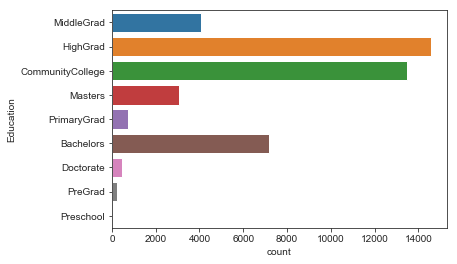

In [10]:
fig = plt.figure() #figsize = (20,3)로 그래프 사이즈 바꿀 수 있음
sns.set_style('ticks')
sns.countplot(y='Education', data=adult)
adult

## 3.2.2. Missing data imputation(공통)

In [11]:
# missing value가 어디에 있는지 출력합니다.
display(adult.isnull().sum())
adult

Age                 0
WorkClass        2530
fnlwgt              0
Education           0
MaritalStatus       0
Occupation       2540
Relationship        0
Race                0
Gender              0
CapitalGain         0
CapitalLoss         0
HoursPerWeek        0
NativeCountry       0
Income              0
dtype: int64

,Age,WorkClass,fnlwgt,Education,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,25,Private,226802,MiddleGrad,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HighGrad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,CommunityCollege,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,CommunityCollege,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,NaN,103497,CommunityCollege,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,0
5,34,Private,198693,MiddleGrad,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,0
6,29,NaN,227026,HighGrad,Never-married,NaN,Unmarried,Black,Male,0,0,40,United-States,0
7,63,Self-emp-not-inc,104626,Masters,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,1
8,24,Private,369667,CommunityCollege,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,0
9,55,Private,104996,PrimaryGrad,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,0


In [12]:
# Most Frequent Imputation으로 missing value를 채워줍니다.
workclass_frequent = adult['WorkClass'].mode()
occupation_frequent = adult['Occupation'].mode()

adult['WorkClass'].fillna('Private', inplace=True)
adult['Occupation'].fillna('Exec-managerial', inplace=True)

display(adult.isnull().sum())

#missing value를 채웠으니 Label Encoding을 해줍니다.
#label_encoder = preprocessing.LabelEncoder()
#adult = adult.apply(label_encoder.fit_transform)
#display(adult.head())
adult

Age              0
WorkClass        0
fnlwgt           0
Education        0
MaritalStatus    0
Occupation       0
Relationship     0
Race             0
Gender           0
CapitalGain      0
CapitalLoss      0
HoursPerWeek     0
NativeCountry    0
Income           0
dtype: int64

,Age,WorkClass,fnlwgt,Education,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,25,Private,226802,MiddleGrad,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HighGrad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,CommunityCollege,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,CommunityCollege,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,Private,103497,CommunityCollege,Never-married,Exec-managerial,Own-child,White,Female,0,0,30,United-States,0
5,34,Private,198693,MiddleGrad,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,0
6,29,Private,227026,HighGrad,Never-married,Exec-managerial,Unmarried,Black,Male,0,0,40,United-States,0
7,63,Self-emp-not-inc,104626,Masters,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,1
8,24,Private,369667,CommunityCollege,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,0
9,55,Private,104996,PrimaryGrad,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,0


## 3.2.3. One-hot encoding

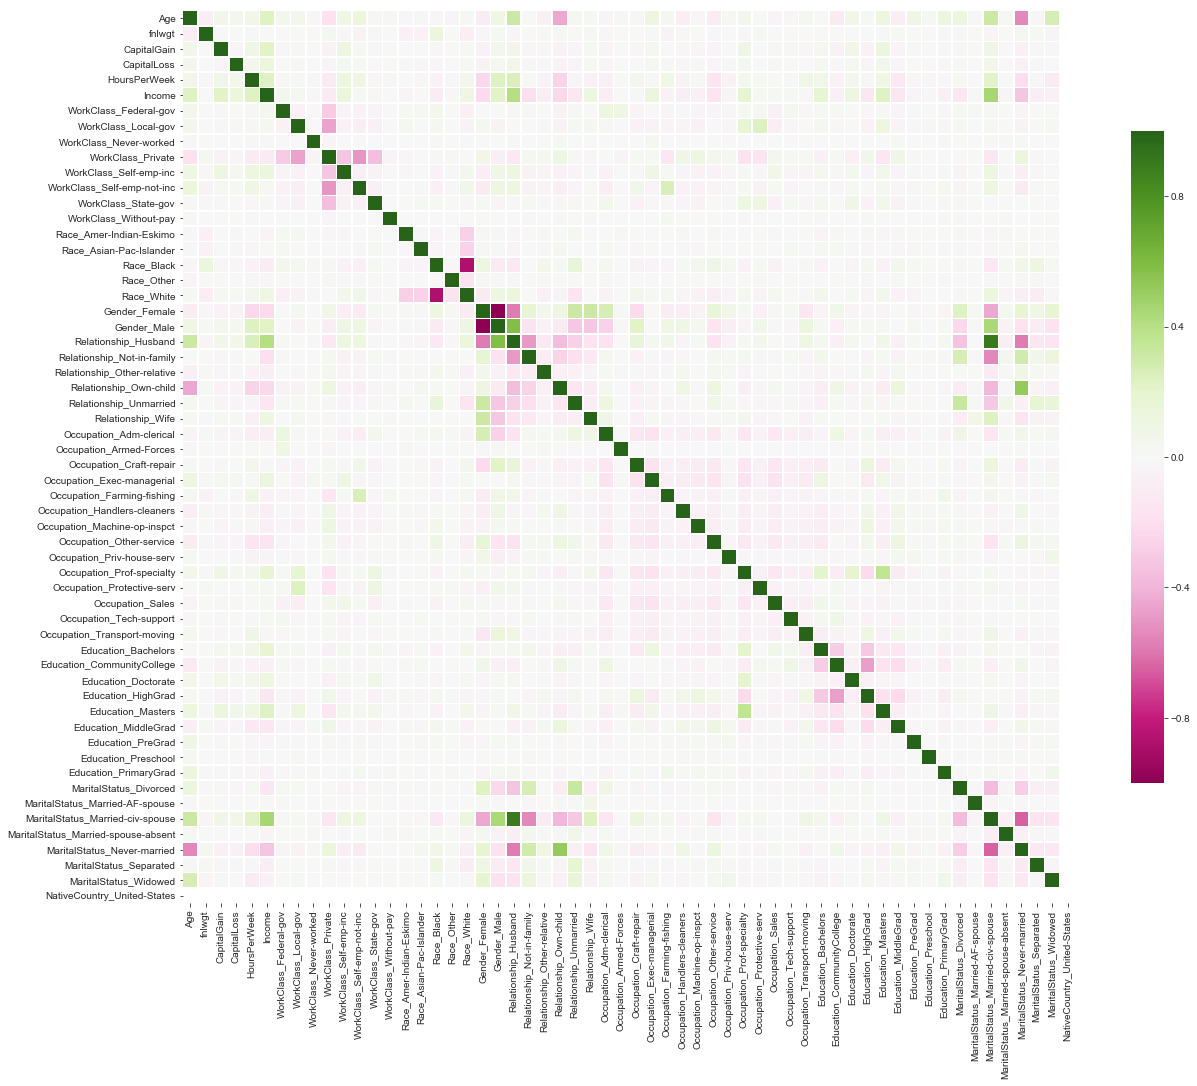

In [14]:
#원핫인코딩을 위해 oneh_df 변수에 복사본 넣고, pandas의 get_dummies 활용 위해 capital gain/loss 자료형을 string으로 변환합니다.
oneh_df = adult.copy()
oneh_df = pd.get_dummies(oneh_df, columns = ['WorkClass', 'Race', 'Gender', 'Relationship', 'Occupation', 'Education', 'MaritalStatus', 'NativeCountry'])
oneh_df

# visualization of correlation
plt.subplots(figsize=(20,20))

sns.heatmap(oneh_df.corr(), cmap="PiYG", square=True, xticklabels=True, yticklabels=True, 
            linewidths=.6, cbar_kws={"shrink": .6})
plt.show()

## 3.3. 모델 구동

이제 본격적으로 모델을 구동해보려 합니다. 우선 모델 구동 전에 연산속도를 위해 데이터를 3000개 sample하고, CV와 test를 위해 sample set을 나눕니다. 그 다음 logistic regression 모델을 구동하며 최적의 결과를 내는 하이퍼파라미터값을 찾고, 모델을 훈련시킨 뒤에는 CV score, Test score, precision, recall, f1, accuracy 등으로 결과값을 출력합니다.

In [12]:
from sklearn.svm import SVC                            #SVM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
import sklearn.metrics as metrics

In [13]:
# 데이터를 3000개 샘플링합니다. 학습에 시간이 좀 걸립니다.
oneh_df = oneh_df.sample(n=3000, random_state=42)

X = oneh_df.iloc[:, oneh_df.columns != 'Income']
y = oneh_df.iloc[:, oneh_df.columns == 'Income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Clean y values to avoid future warning messages
# for 'ravel()', refer to 'https://docs.scipy.org/doc/numpy/reference/generated/numpy.ravel.html'.
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)

In [14]:
svm = SVC()
param_svm = {'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10], 'decision_function_shape': ['ovo', 'ovr']}

# Select Best parameter using GridSearchCV and 5-fold Cross Validation
# We'll use scaled data like MLP to prevent overfitting.
svm_grid = GridSearchCV(svm, param_svm, cv=5)
svm_grid.fit(X_train, y_train)

print('======== Support Vector Machine Result ========')
print('Test set score: {:.3f}'.format(svm_grid.score(X_test, y_test)))
print('Best Parameter: {}'.format(svm_grid.best_params_))
print('Best CV score: {:.3f}'.format(svm_grid.best_score_))
print('<<Classification Result>>\n', classification_report(y_test, svm_grid.predict(X_test)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

======== Support Vector Machine Result ========
Test set score: 0.849
Best Parameter: {'C': 1, 'decision_function_shape': 'ovo'}
Best CV score: 0.840
<<Classification Result>>
               precision    recall  f1-score   support

           0       0.88      0.93      0.90      1537
           1       0.71      0.59      0.64       463

    accuracy                           0.85      2000
   macro avg       0.80      0.76      0.77      2000
weighted avg       0.84      0.85      0.84      2000

